# Product Sales Analysis Report

### Necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

## Load data

In [3]:
df = pd.read_csv('product_sales.csv')

In [4]:
df.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


## Structure of data

In [5]:
#Check how data looks
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
#Checingk for unique values in sales_method col
unique_values = df['sales_method'].unique()
print(unique_values)

['Email' 'Email + Call' 'Call' 'em + call' 'email']


In [7]:
#Looking for missing values in data
print("\nMissing values:")
df.isnull().sum()


Missing values:


week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64

In [8]:
#Checking for any outliers
df.describe()

,week,nb_sold,revenue,years_as_customer,nb_site_visits
count,15000.000000,15000.000000,13926.000000,15000.000000,15000.000000
mean,3.098267,10.084667,93.934943,4.965933,24.990867
std,1.656420,1.812213,47.435312,5.044952,3.500914
min,1.000000,7.000000,32.540000,0.000000,12.000000
25%,2.000000,9.000000,52.470000,1.000000,23.000000
50%,3.000000,10.000000,89.500000,3.000000,25.000000
75%,5.000000,11.000000,107.327500,7.000000,27.000000
max,6.000000,16.000000,238.320000,63.000000,41.000000


### Overwiev

##### Sales Method Column
- 5 different methods present
- Should only have 3 types of methods

##### Revenue Column
- 1074 missing values identified

##### Years as Customer Column
- Contains outliers
- Company founded in 1984
- Impossible to have customers for 63 years


## Data Cleaning and Preprocessing

In [9]:
# We know that in column sales_method should be 3 unique values, so we need to take care of that
# Standardize sales_method values
df['sales_method'] = df['sales_method'].replace({'em + call': 'Email + Call', 'email': 'Email'})
print("Unique values in the sales_method column after replacement:", df['sales_method'].unique() )

Unique values in the sales_method column after replacement: ['Email' 'Email + Call' 'Call']


In [10]:
#Checking howy many wrong records we have
(df['years_as_customer'] > 40).sum()

2

In [11]:
#Display error rows
df[df['years_as_customer']>40]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


In [12]:
#Create new dataframe for processed data
df_clean = df[df['years_as_customer'] <= 40]

In [13]:
(df_clean['years_as_customer'] > 40).sum()

0

In [14]:
#Moving to the revenue col
#Calculate the percentage of missing values
missing_percentage = (df_clean['revenue'].isnull().sum() / len(df_clean)) * 100
print(f"Percentage of missing revenue values: {missing_percentage:.2f}%")

Percentage of missing revenue values: 7.16%


In [15]:
# Check if missing values are random or follow a pattern
print("Distribution of missing values across sales methods:")
print(df_clean[df_clean['revenue'].isnull()]['sales_method'].value_counts(normalize=True))

Distribution of missing values across sales methods:
Email           0.506518
Email + Call    0.324953
Call            0.168529
Name: sales_method, dtype: float64


In [16]:
df_clean.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


In [17]:
# Eexamining the relationship between missing values in the 'revenue' column and the 'sales_method' column

# Create a new categorical column for revenue
df_clean['revenue_status'] = df_clean['revenue'].apply(lambda x: 'Missing' if pd.isna(x) else 'Present')

# Display unique values in the new column for verification
print("Values in revenue_status column:", df_clean['revenue_status'].unique())


Values in revenue_status column: ['Missing' 'Present']


C:\Users\Karez\AppData\Local\Temp\ipykernel_12904\1978540786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['revenue_status'] = df_clean['revenue'].apply(lambda x: 'Missing' if pd.isna(x) else 'Present')


In [18]:
df_clean.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state,revenue_status
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona,Missing
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas,Present
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin,Present
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana,Missing
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois,Present


In [19]:
# Analyze relationship between sales methods and revenue data availability

# Create a cross-tabulation
cross_tab = pd.crosstab(df_clean['sales_method'], df_clean['revenue_status'])

# Display the cross-tabulation
print("Cross-tabulation of sales methods and revenue status:")
print(cross_tab)

# Conduct chi-square test
chi_square_stat, p_val, _, _ = chi2_contingency(cross_tab)

# Output test results
print(f"\nChi-square statistic: {chi_square_stat:.4f}")
print(f"p-value: {p_val}")

# Interpret results
significance_threshold = 0.05
if p_val < significance_threshold:
    print("\nEvidence suggests a significant association between sales methods and revenue data availability.")
else:
    print("\nInsufficient evidence to conclude an association between sales methods and revenue data availability.")

Cross-tabulation of sales methods and revenue status:
revenue_status  Missing  Present
sales_method                    
Call                181     4780
Email               544     6921
Email + Call        349     2223

Chi-square statistic: 251.1178
p-value: 2.954295391738752e-55

Evidence suggests a significant association between sales methods and revenue data availability.


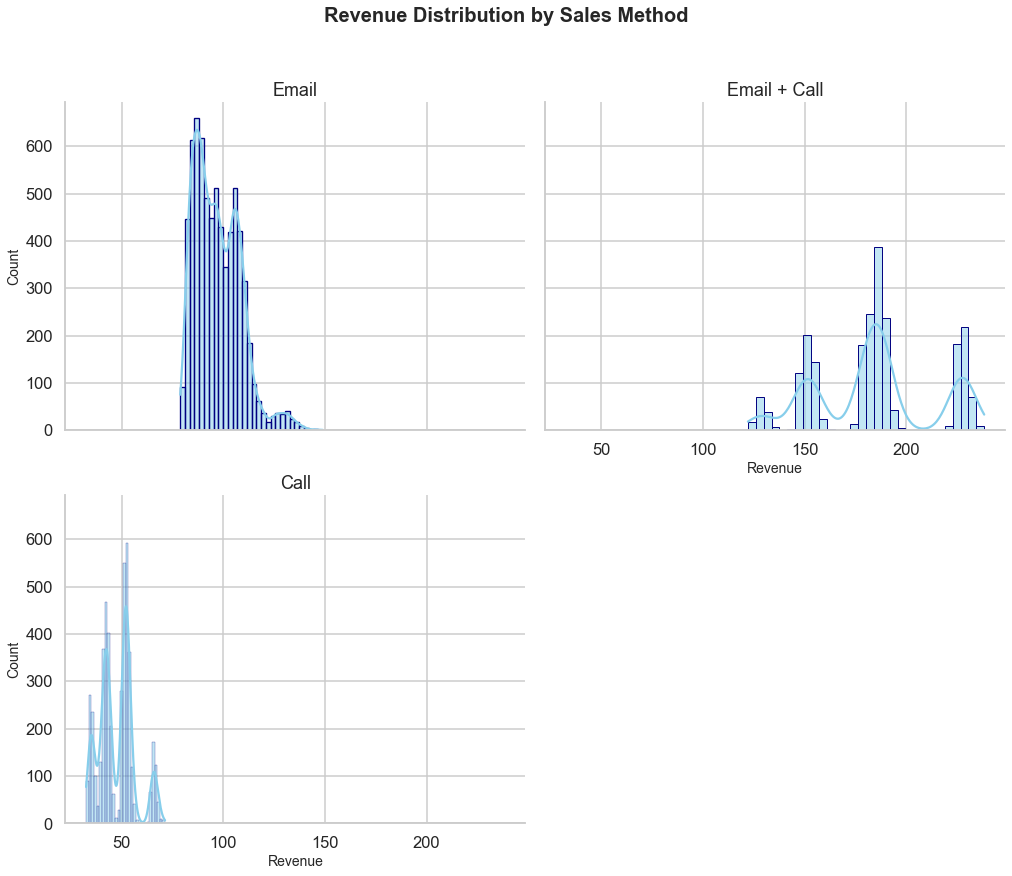

In [20]:
# The relationship between 'sales_method' and 'revenue_category' means we can't simply drop missing values.
# Doing so could bias analysis. We need to consider alternative approaches to handle this missing data.
sns.set_style("whitegrid")
sns.set_context("talk")  # Increases font sizes for better readability

# Set color palette
sns.set_palette("deep")  # Changed to 'deep' for more vibrant colors

# Create a larger facet grid using seaborn
g = sns.FacetGrid(df_clean, col="sales_method", height=6, aspect=1.2, col_wrap=2)

# Map histograms for 'revenue' onto the grid
g.map(sns.histplot, "revenue", bins=30, kde=True, color="skyblue", edgecolor="navy")

# Add titles with larger font size
g.set_titles("{col_name}")

# Add overall title
g.fig.suptitle("Revenue Distribution by Sales Method", fontsize=20, y=1.02, fontweight='bold')

# Adjust x and y labels
g.set_axis_labels("Revenue", "Count", fontsize=14)

# Adjust layout
g.tight_layout()

# Show the plot
plt.show()

In [21]:
# Impute missing values with median for each sales method
df_clean['revenue'] = df_clean.groupby('sales_method')['revenue'].transform(lambda x: x.fillna(x.median()))
print("\nRemaining missing values in revenue column:", df_clean['revenue'].isnull().sum())


Remaining missing values in revenue column: 0


C:\Users\Karez\AppData\Local\Temp\ipykernel_12904\2818459931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['revenue'] = df_clean.groupby('sales_method')['revenue'].transform(lambda x: x.fillna(x.median()))


In [22]:
df_clean

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state,revenue_status
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,95.58,0,24,Arizona,Missing
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas,Present
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin,Present
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,95.58,3,25,Indiana,Missing
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois,Present
...,...,...,...,...,...,...,...,...,...
14995,4,Call,17267b41-d048-4346-8b90-7f787690a836,10,50.82,0,22,Pennsylvania,Present
14996,5,Call,09e10d6f-4508-4b27-895e-4db11ce8302b,10,52.33,1,27,Kansas,Present
14997,1,Call,839653cb-68c9-48cb-a097-0a5a3b2b298b,7,34.87,4,22,West Virginia,Present
14998,6,Call,e4dad70a-b23b-407c-8bd3-e32ea00fae17,13,64.90,2,27,New Jersey,Present


In [23]:
df_clean
df_clean.drop('revenue_status', axis=1, inplace=True)
df_clean = df_clean.reset_index(drop=True)

C:\Users\Karez\AppData\Local\Temp\ipykernel_12904\3407902879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop('revenue_status', axis=1, inplace=True)


In [24]:
df_clean

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,95.58,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,95.58,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois
...,...,...,...,...,...,...,...,...
14993,4,Call,17267b41-d048-4346-8b90-7f787690a836,10,50.82,0,22,Pennsylvania
14994,5,Call,09e10d6f-4508-4b27-895e-4db11ce8302b,10,52.33,1,27,Kansas
14995,1,Call,839653cb-68c9-48cb-a097-0a5a3b2b298b,7,34.87,4,22,West Virginia
14996,6,Call,e4dad70a-b23b-407c-8bd3-e32ea00fae17,13,64.90,2,27,New Jersey


In [25]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14998 entries, 0 to 14997
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               14998 non-null  int64  
 1   sales_method       14998 non-null  object 
 2   customer_id        14998 non-null  object 
 3   nb_sold            14998 non-null  int64  
 4   revenue            14998 non-null  float64
 5   years_as_customer  14998 non-null  int64  
 6   nb_site_visits     14998 non-null  int64  
 7   state              14998 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.5+ KB


## 3. Exploratory Data Analysis

### 3.1 Single Variable Analysis

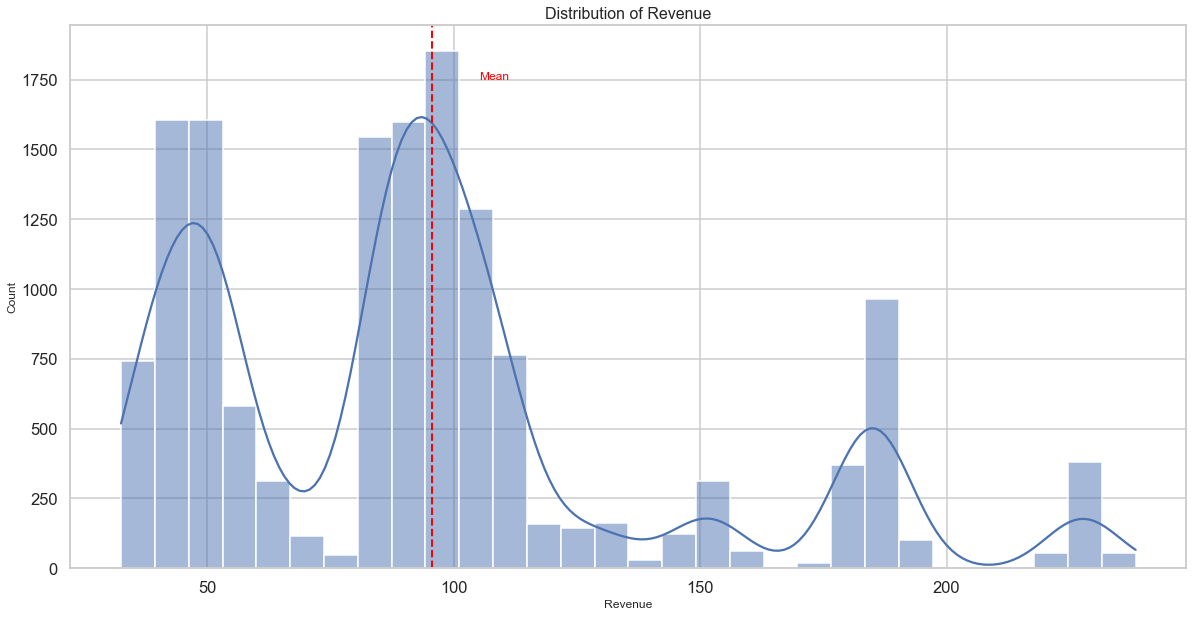

In [26]:
#Distribution of Revenue
plt.figure(figsize=(20, 10))
sns.histplot(df_clean['revenue'], kde=True, bins=30)
plt.title('Distribution of Revenue', fontsize=16)
plt.xlabel('Revenue', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(df_clean['revenue'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.text(df_clean['revenue'].mean()*1.1, plt.gca().get_ylim()[1]*0.9, 'Mean', color='red', fontsize=12)
plt.show()

###
- The distribution of revenues is right-skewed and also mean (indicated by the red dashed line) is higher than the median which confirms the right-skewness.
- There are several distinct peaks in the distribution, suggesting different price categories or product types.
- The highest concentration of revenues is in the 50-100 unit range.
- There are a significant number of lower-value transactions (less than 50 units).
- There are also high-value transactions (above 150 units), but they are less numerous.

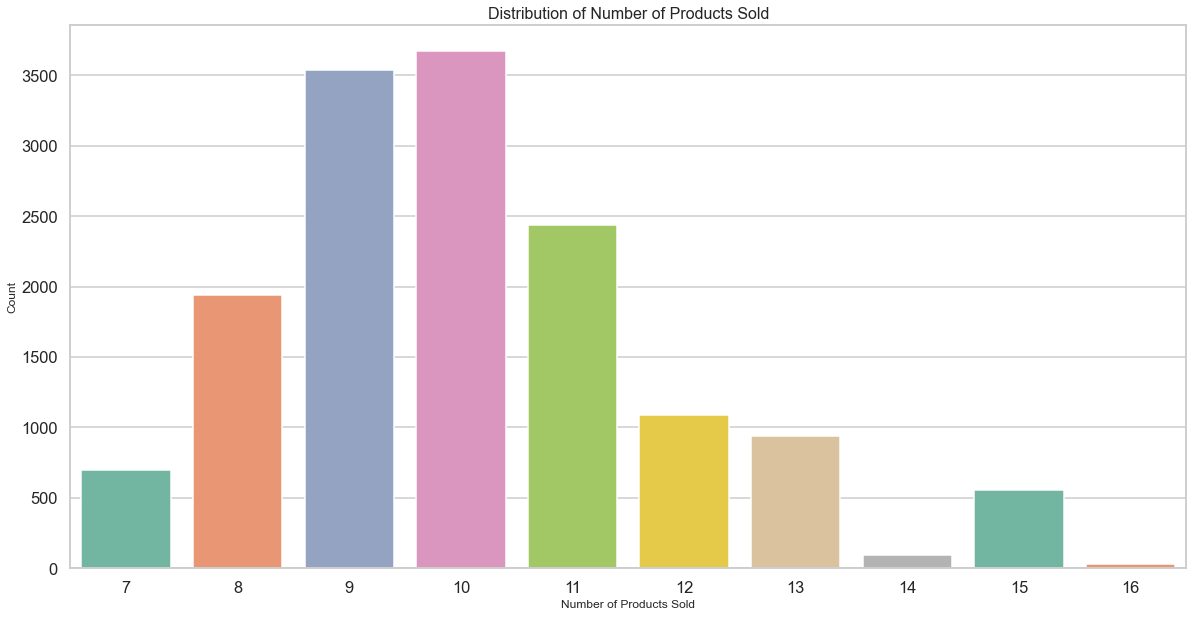

In [27]:
#Distribution of Number of Products Sold
plt.figure(figsize=(20, 10))
sns.countplot(x='nb_sold', data=df_clean, palette='Set2')
plt.title('Distribution of Number of Products Sold', fontsize=16)
plt.xlabel('Number of Products Sold', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

###
- The most common number of products sold per transaction is 10, followed closely by 9.
- There's a relatively normal distribution centered around 9-10 products.
- Sales of 7-8 products and 11-13 products are also common, but less frequent.
- There's a sharp decline in frequency for sales of 14 or more products.
- Very few transactions involve 16 or more products.

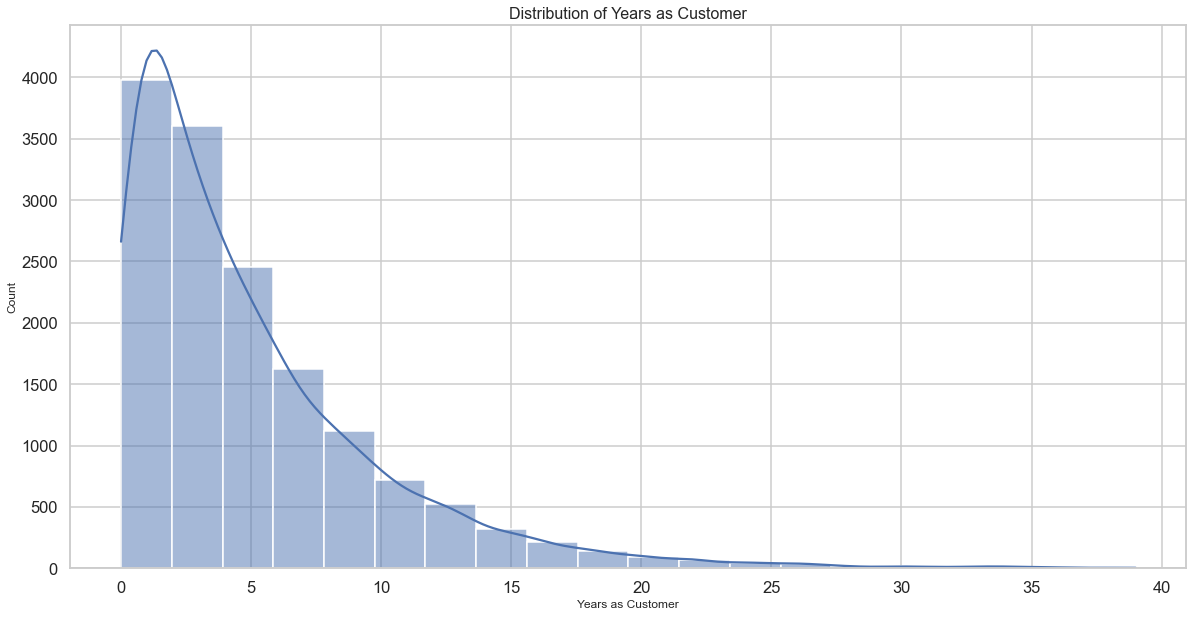

In [28]:
#Distribution of Years as Customer
plt.figure(figsize=(20, 10))
sns.histplot(df_clean['years_as_customer'], kde=True, bins=20)
plt.title('Distribution of Years as Customer', fontsize=16)
plt.xlabel('Years as Customer', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

###
- There's a sharp decline in customer retention over time.
- The highest number of customers are in their first year (0-1 years).
- There's a rapid drop-off in the number of customers after the first few years.
- Very few customers remain after 20 years.
- The curve follows an exponential decay pattern, typical for customer retention.

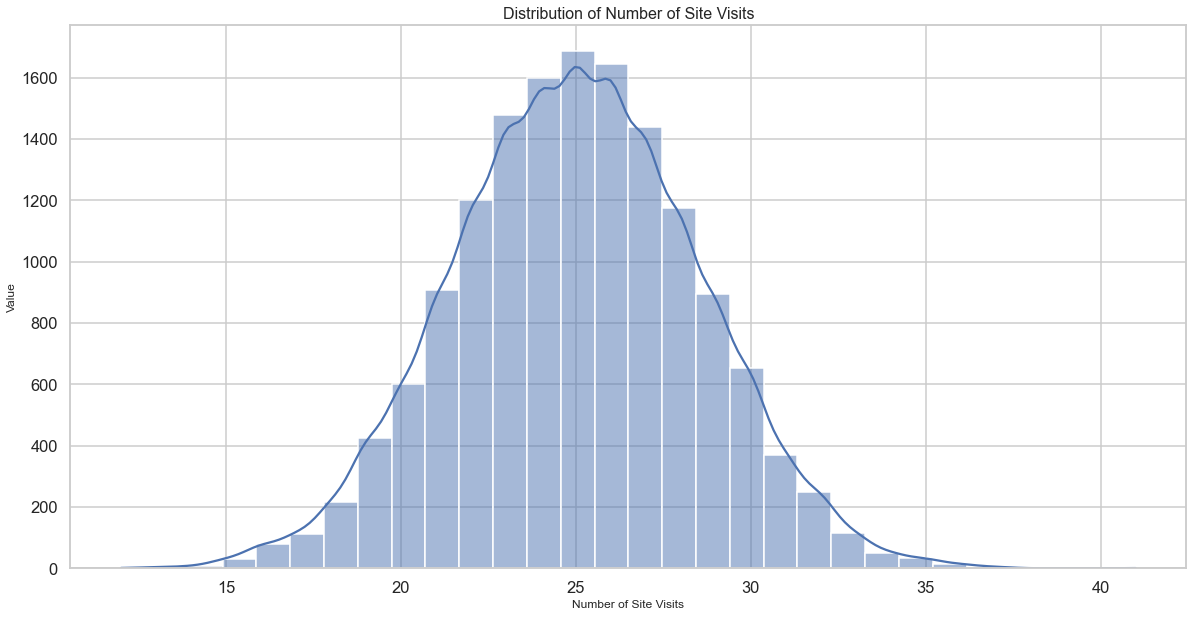

In [29]:
#Distribution of Number of Site Visits
plt.figure(figsize=(20, 10))
sns.histplot(df_clean['nb_site_visits'], kde=True, bins=30)
plt.title('Distribution of Number of Site Visits', fontsize=16)
plt.xlabel('Number of Site Visits', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()

###
- The distribution of site visits follows a roughly normal distribution.
- The peak of the distribution is around 25-27 visits.
- There's a wide range of visit frequencies, from about 15 to 35 visits.
- Very few customers visit less than 15 times or more than 35 times in the given period.

### 2.2 Multi-Variable Analysis

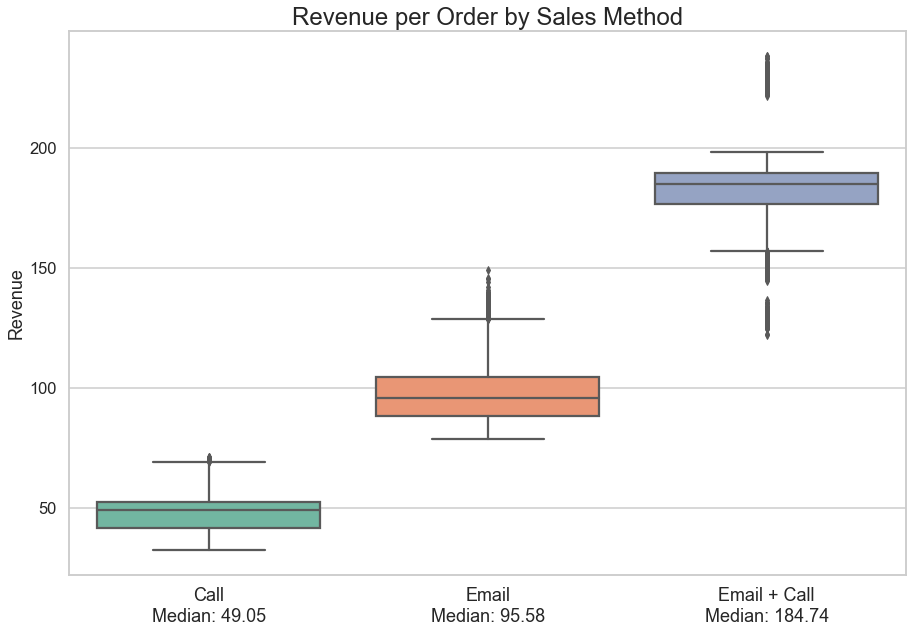

In [30]:
median_revenue = df_clean.groupby('sales_method')['revenue'].median().sort_values(ascending=True)
plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='sales_method', y='revenue', data=df_clean, palette='Set2', order=median_revenue.index)

plt.title('Revenue per Order by Sales Method', fontsize=24)
plt.ylabel('Revenue', fontsize=18)

# Create x-axis labels with sales method names and median values
x_labels = [f"{method}\nMedian: {median_revenue[method]:.2f}" for method in median_revenue.index]

# Set x-axis labels
plt.xticks(range(len(median_revenue.index)), x_labels, fontsize=18)

# Remove default x-axis label as the information is now in the tick labels
plt.xlabel('')

plt.show()

###
- Email + Call method generates the highest median revenue per order at 184.74
- Email is the second most effective method with a median revenue of 95.58 per order
- Call-only method has the lowest median revenue at 49.05 per order
- Email + Call method shows the widest range of revenue, indicating more variability
- All methods show some outliers, particularly on the higher end of revenue

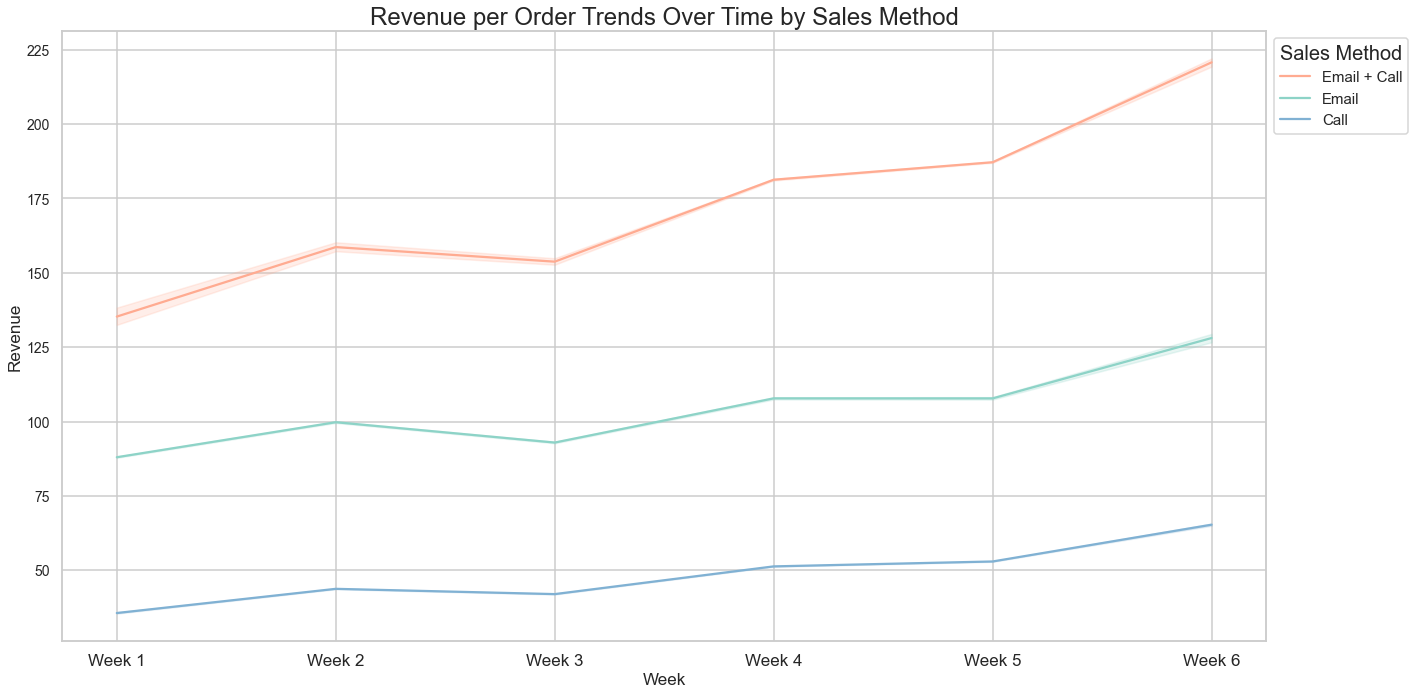

In [31]:
plt.figure(figsize=(20, 10))
color_dict = {'Email': '#8dd3c7', 'Email + Call': '#ffab91', 'Call': '#80b1d3'}
for method in ['Email + Call', 'Email', 'Call']:
    method_data = df_clean[df_clean['sales_method'] == method]
    sns.lineplot(x='week', y='revenue', data=method_data, label=method, color=color_dict[method])

plt.title('Revenue per Order Trends Over Time by Sales Method', fontsize=24)
plt.xlabel('Week', fontsize=17)
plt.ylabel('Revenue', fontsize=17)
plt.xticks(range(1, 7), ['Week '+str(i) for i in range(1, 7)], fontsize=17)
plt.yticks(fontsize=14)
plt.legend(title='Sales Method', title_fontsize='20', fontsize='15', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

###
- Email + Call consistently generates the highest revenue per order across all weeks
- Email + Call shows a strong upward trend, especially from Week 3 onwards
- Email method revenue per order is relatively stable with a slight increase over time
- Call-only method generates the lowest revenue per order but shows a gradual upward trend
- All methods show some fluctuations, with a noticeable dip around Week 3 for Email + Call and Email

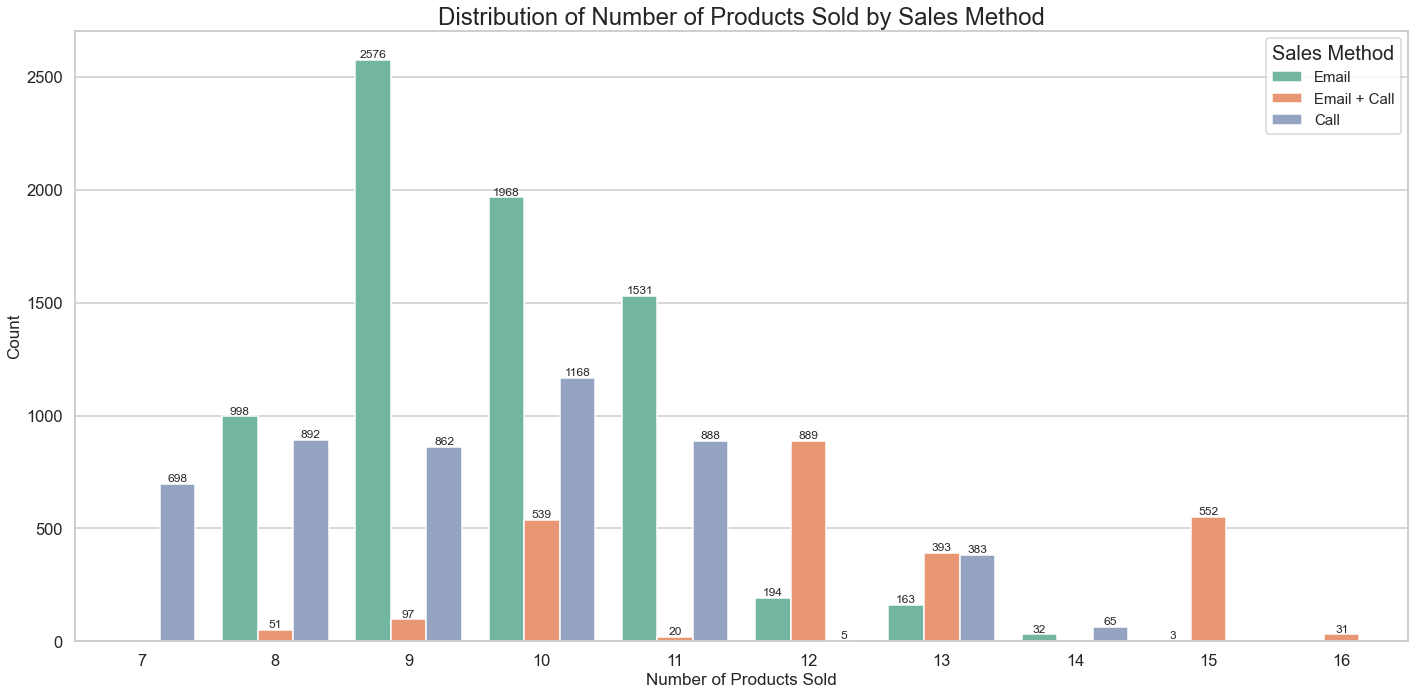

In [32]:
plt.figure(figsize=(20, 10))
ax = sns.countplot(x='nb_sold', hue='sales_method', data=df_clean, palette='Set2')
plt.title('Distribution of Number of Products Sold by Sales Method', fontsize=24)
plt.xlabel('Number of Products Sold', fontsize=17)
plt.ylabel('Count', fontsize=17)
plt.legend(title='Sales Method', title_fontsize='20', fontsize='15', loc='upper right')
for container in ax.containers:
    ax.bar_label(container, fontsize=12)
plt.tight_layout()
plt.show()

###
- Email is the dominant sales method for selling 7-11 products
- Email + Call becomes more prevalent for larger orders (12-16 products)
- Call-only method is consistently used across all product quantities but is not the leading method for any specific quantity
- The most common number of products sold is 9, followed closely by 10
- There's a sharp decline in sales frequency for orders of 14 or more products

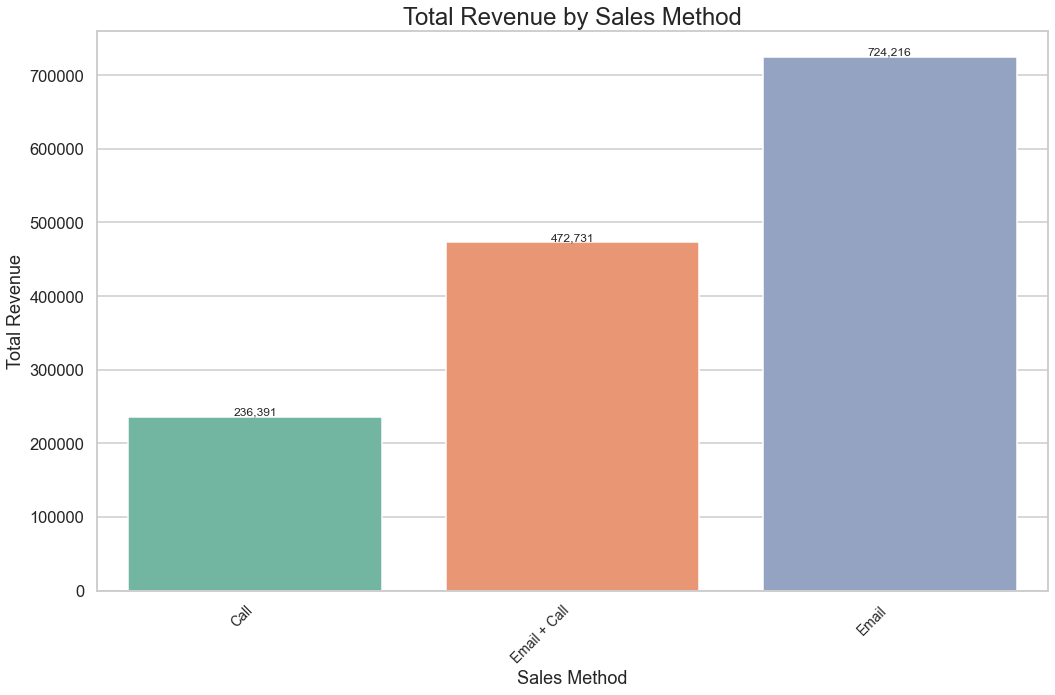

In [33]:
# Calculate the sum of revenue for each sales method
total_revenue = df_clean.groupby('sales_method')['revenue'].sum().sort_values(ascending=True)

plt.figure(figsize=(15, 10))
ax = sns.barplot(x=total_revenue.index, y=total_revenue.values, palette='Set2')

plt.title('Total Revenue by Sales Method', fontsize=24)
plt.ylabel('Total Revenue', fontsize=18)
plt.xlabel('Sales Method', fontsize=18)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=14)

# Add value labels on top of each bar
for i, v in enumerate(total_revenue.values):
    ax.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

###
- Email is the highest revenue-generating method, with a total of $724,216
- Email + Call is the second most effective method, generating $472,731
- Call-only method has the lowest total revenue at $236,391
- Email method generates significantly more revenue than the other two methods combined
- The difference between Email and Email + Call methods is substantial, with Email generating about 53% more revenue

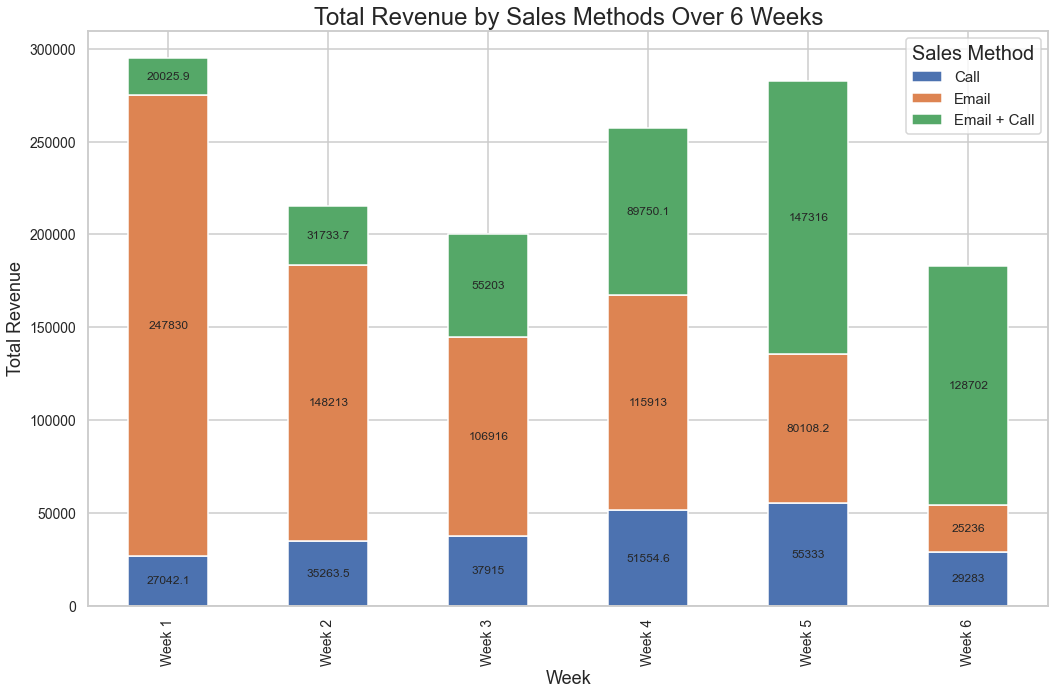

In [34]:
revenue_data = df_clean.groupby(['week', 'sales_method'])['revenue'].sum().unstack()

# Create a stacked bar plot
ax = revenue_data.plot(kind='bar', stacked=True, figsize=(15, 10))

plt.title('Total Revenue by Sales Methods Over 6 Weeks', fontsize=24)
plt.xlabel('Week', fontsize=18)
plt.ylabel('Total Revenue', fontsize=18)
plt.xticks(range(6), ['Week '+str(i) for i in range(1, 7)], fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Sales Method', title_fontsize='20', fontsize='15', loc='upper right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center', fontsize=12)

plt.tight_layout()
plt.show()

###
- Week 1 shows the highest total revenue, with Email being the dominant method
- There's a general decline in total revenue from Week 1 to Week 6
- Email method's dominance decreases over time, especially from Week 4 onwards
- Email + Call method shows an increasing trend, becoming more significant in later weeks
- Call-only method remains relatively stable but shows a slight increase in later weeks
- Week 5 sees a notable increase in the Email + Call method, surpassing Email
- Week 6 shows a significant drop in Email method usage, with Email + Call becoming the primary revenue generator

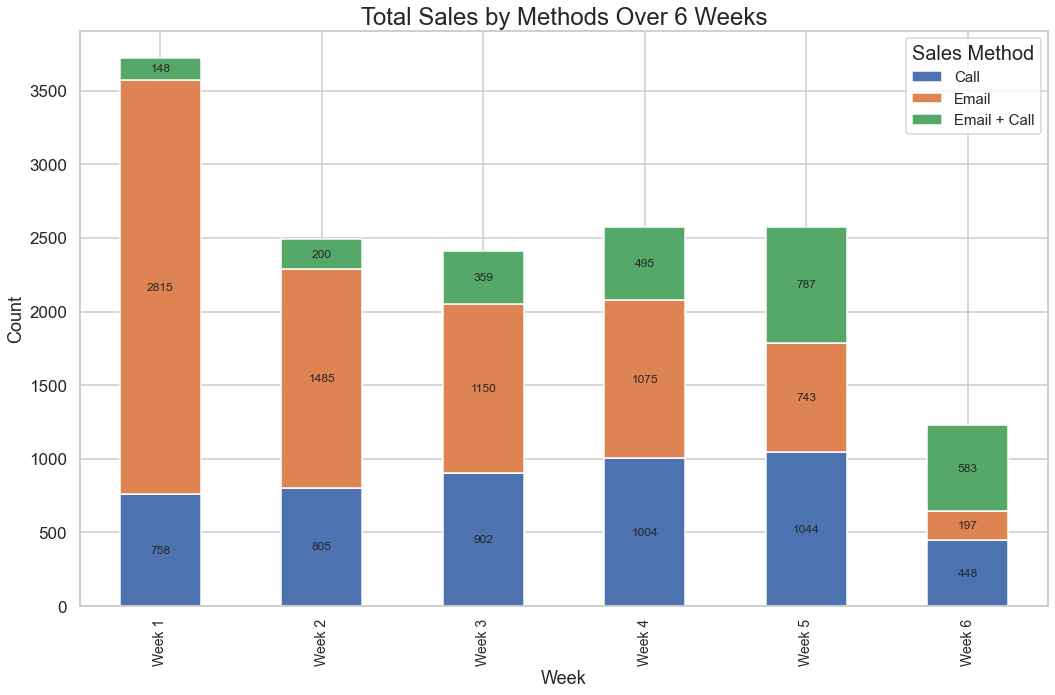

In [35]:
df_stacked = df_clean.groupby(['week', 'sales_method']).size().unstack(fill_value=0)

# Create the stacked bar plot
ax = df_stacked.plot(kind='bar', stacked=True, figsize=(15, 10))

plt.title('Total Sales by Methods Over 6 Weeks', fontsize=24)
plt.xlabel('Week', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(range(6), ['Week '+str(i) for i in range(1, 7)], fontsize=14)
plt.yticks(fontsize=17)
plt.legend(title='Sales Method', title_fontsize='20', fontsize='15', loc='upper right')

# Add labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center', fontsize=12)

plt.tight_layout()
plt.show()

###
- Email is consistently the most used sales method across all weeks
- There's a noticeable decline in email usage from Week 1 to Week 6
- Email + Call method shows an increasing trend, especially in later weeks
- Call-only method usage remains relatively stable throughout the period
- Week 1 shows the highest overall sales activity, with a general decline in subsequent weeks

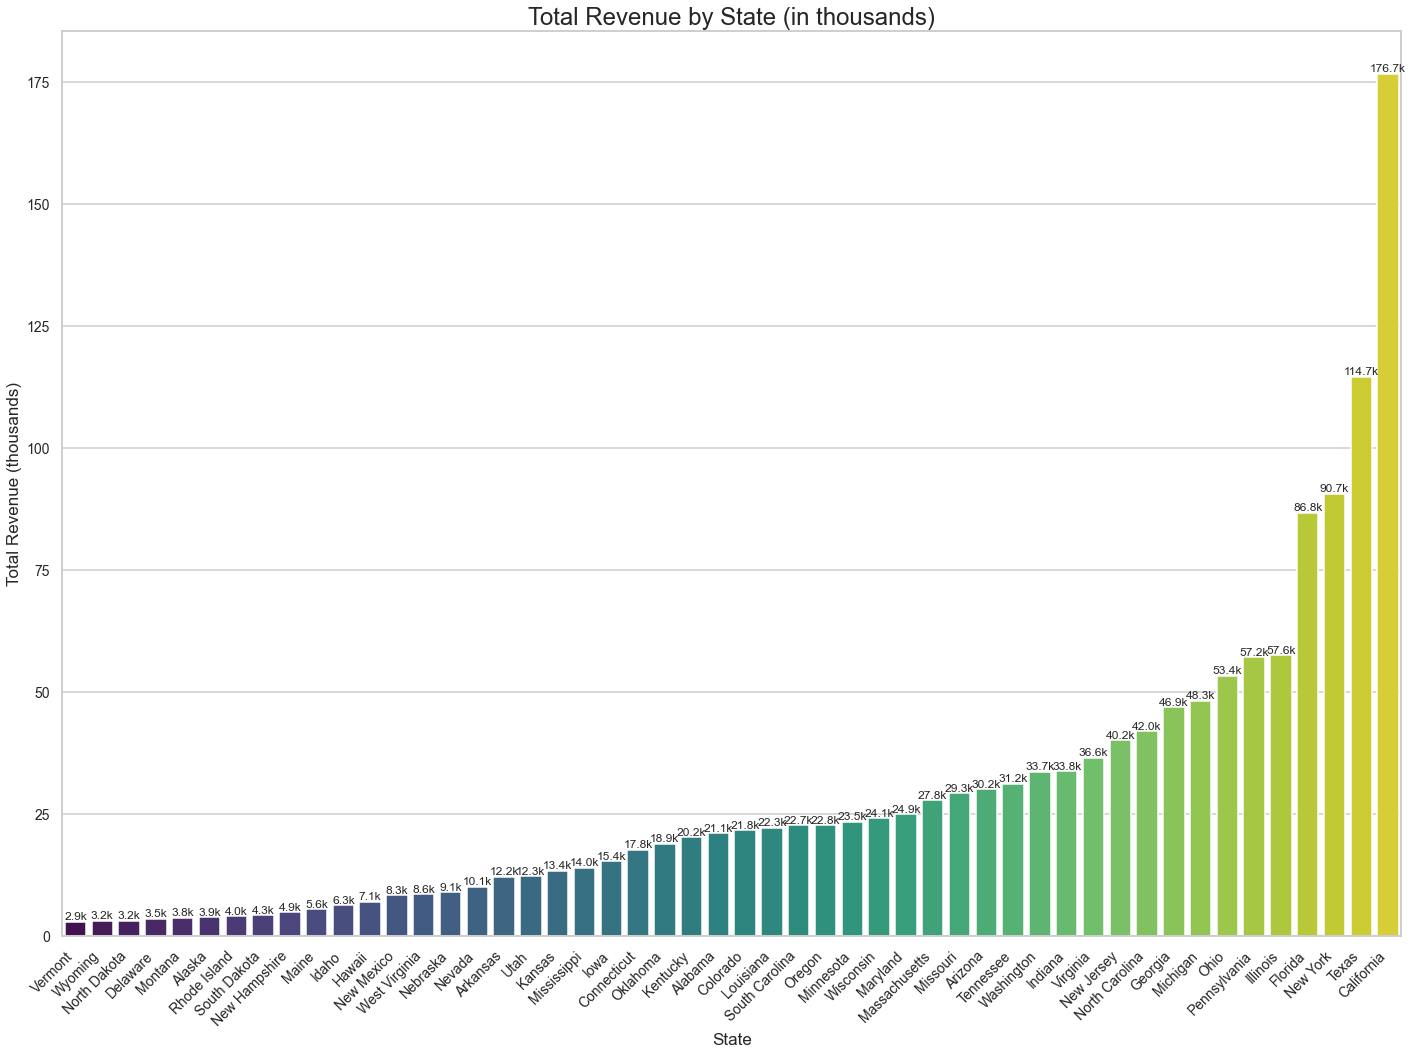

In [36]:
# Grouping data by state and summing revenue, then dividing by 1000
state_revenue = (df_clean.groupby('state')['revenue'].sum() / 1000).sort_values()

plt.figure(figsize=(20, 15))
sns.barplot(x=state_revenue.index, y=state_revenue.values, palette='viridis')

plt.title('Total Revenue by State (in thousands)', fontsize=24)
plt.xlabel('State', fontsize=17)
plt.ylabel('Total Revenue (thousands)', fontsize=17)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Adding value labels on top of the bars, formatted to show thousands
for i, v in enumerate(state_revenue.values):
    plt.text(i, v, f'{v:.1f}k', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


###
- California generates the highest total revenue by a significant margin
- New York and Texas are the next highest revenue-generating states
- There's a substantial gap between the top few states and the rest
- The revenue distribution across states is highly uneven, with a few states dominating the total revenue

## Definition of Metrics for the Business to Monitor

Proposing a set of interconnected metrics called the Customer Engagement and Value Index (CEVI):

1. Customer Lifetime Value (CLV):
   CLV = Total Revenue / (Years as Customer * Number of Orders)

2. Engagement Efficiency (EE):
   EE = Number of Orders / Number of Site Visits

3. Average Order Value (AOV):
   AOV = Total Revenue / Number of Orders

4. Customer Engagement and Value Index (CEVI):
   CEVI = (CLV * EE * AOV) ^ (1/3)

This composite metric balances long-term value, engagement efficiency, and transaction size.

## How the Business Should Use the Metrics

1. Track CEVI and its components over time for each sales method.
2. Use CEVI to compare the overall effectiveness of different sales methods.
3. Analyze trends in individual components (CLV, EE, AOV) to identify specific areas for improvement.
4. Segment customers based on CEVI to tailor marketing and sales strategies.
5. Use CEVI to evaluate the impact of new initiatives or changes in sales strategies.

In [37]:
def calculate_cevi(df):
    metrics = df.groupby('sales_method').agg({
        'revenue': 'sum',
        'years_as_customer': 'mean',
        'nb_site_visits': 'sum',
        'customer_id': pd.Series.nunique
    }).reset_index()
    
    metrics['CLV'] = metrics['revenue'] / (metrics['years_as_customer'] * metrics['customer_id'])
    metrics['EE'] = metrics['customer_id'] / metrics['nb_site_visits']
    metrics['AOV'] = metrics['revenue'] / metrics['customer_id']
    metrics['CEVI'] = np.cbrt(metrics['CLV'] * metrics['EE'] * metrics['AOV'])
    
    return metrics.sort_values('CEVI', ascending=False)

cevi_results = calculate_cevi(df_clean)
print(cevi_results[['sales_method', 'CLV', 'EE', 'AOV', 'CEVI']])

   sales_method        CLV        EE         AOV      CEVI
2  Email + Call  40.777275  0.037353  183.798970  6.541793
1         Email  19.496477  0.040397   97.014887  4.243398
0          Call   9.219621  0.040945   47.649883  2.620134


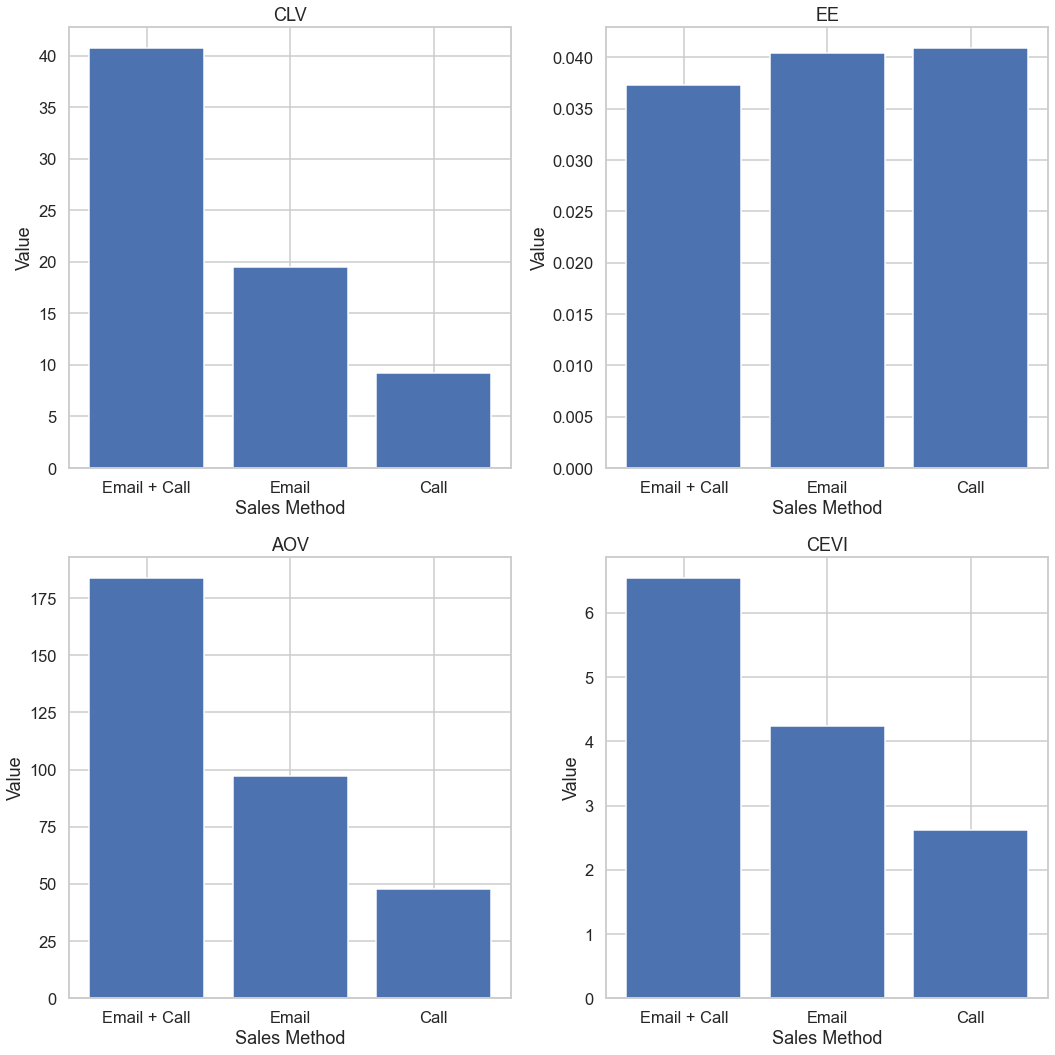

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
metrics = ['CLV', 'EE', 'AOV', 'CEVI']
for i, metric in enumerate(metrics):
    ax = axs[i//2, i%2]
    ax.bar(cevi_results['sales_method'], cevi_results[metric])
    ax.set_title(metric)
    ax.set_ylabel('Value')
    ax.set_xlabel('Sales Method')
plt.tight_layout()
plt.show()


## Recommendations
1. Implement a phased approach:
   - Launch with email-only campaigns to capitalize on initial interest and efficiency.
   - Gradually introduce the Email and Call combination from Week 3 onwards to build deeper customer relationships.

2. Optimize email content:
   - Focus on creating compelling initial product launch emails.
   - Develop targeted follow-up emails for Week 3 to maintain engagement.

3. Streamline call processes:
   - Train sales team to conduct efficient 10-minute calls as part of the Email and Call strategy.
   - Use insights from email responses to personalize call content.

4. Resource allocation:
   - Allocate more resources to email marketing in the first two weeks.
   - Shift resources towards the combined Email and Call approach from Week 3 onwards.



## Final Summary:
The data reveals a dynamic shift in sales effectiveness across different methods over time. Email marketing shows exceptional initial performance, generating high returns with minimal effort, particularly in the early weeks. 
This aligns with the description of email requiring "very little work for the team." 
However, as the campaign progresses, the combined Email and Call method gains significant momentum, eventually outperforming other approaches in later weeks.
The Call-only method, while consistent, shows lower overall performance, likely due to the high time investment (30 minutes per customer) required. 
The Email and Call combination, despite its initial lag, proves to be the most effective long-term strategy, balancing the efficiency of emails with the personalization of shorter (10-minute) calls.
